In [1]:
import os
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataset import Dataset
from pipeline import Pipeline
from visualizations import Visualizer
from sklearn.linear_model import Ridge
import sklearn.preprocessing
from sklearn.svm import LinearSVR, SVR
from sklearn.decomposition import PCA, KernelPCA
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import mean_squared_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
rmse = MeanSquaredError(square_root = True)
from scipy.linalg import LinAlgWarning
import sklearn.model_selection
import warnings
# Filter out LinAlgWarning
warnings.filterwarnings("ignore", category=LinAlgWarning)
#controling whether tensorflow does recognize GPU
tf.config.get_visible_devices("GPU")
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
#Inititate processing pipeline
pipeline = Pipeline(crypto_tick = "btc")
#Initiate visualizer
visualizer = Visualizer()

In [3]:
# print("Missing values distribution:")
# visualizer.get_missing_columns(data = pipeline.data)

In [4]:
# fig = visualizer.draw_missing_data(data = pipeline.data)
# plt.tight_layout()
# fig.savefig("./../text/Figures/BTC_missing_1.pdf", dpi=300, format="pdf")

# fig.show()

In [5]:
pipeline.set_beginning(start_date = "2014-9-17")

In [6]:
# fig = visualizer.draw_missing_data(data = pipeline.data)
# plt.tight_layout()
# fig.savefig("../text/Figures/BTC_missing_2.pdf", dpi=300, format="pdf")
# fig.show()

In [7]:
pipeline.preprocess_dataset()

In [8]:
# fig = visualizer.draw_missing_data(data = pipeline.data)
# fig.show()

In [9]:
pipeline.data.columns

Index(['BTC / Addresses, active, count', 'BTC / NVT, adjusted, 90d MA',
       'BTC / NVT, adjusted, free float,  90d MA', 'BTC / NVT, adjusted',
       'BTC / NVT, adjusted, free float', 'BTC / Flow, in, to exchanges, USD',
       'BTC / Flow, out, from exchanges, USD',
       'BTC / Fees, transaction, mean, USD',
       'BTC / Fees, transaction, median, USD', 'BTC / Fees, total, USD',
       'BTC / Miner revenue, USD',
       'BTC / Capitalization, market, free float, USD',
       'BTC / Capitalization, realized, USD',
       'BTC / Capitalization, market, current supply, USD',
       'BTC / Capitalization, market, estimated supply, USD',
       'BTC / Volatility, daily returns, 30d',
       'BTC / Volatility, daily returns, 180d', 'BTC / Difficulty, last',
       'BTC / Difficulty, mean', 'BTC / Hash rate, mean',
       'BTC / Hash rate, mean, 30d', 'BTC / Revenue, per hash unit, USD',
       'BTC / Supply, Miner, held by all mining entities, USD',
       'BTC / Block, size, mean, b

In [10]:
pipeline.data.drop(columns = ['BTC / NVT, adjusted, free float,  90d MA',
                              'BTC / NVT, adjusted, free float',
                              'BTC / Fees, transaction, median, USD', 'BTC / Fees, total, USD',
                              'BTC / Capitalization, market, free float, USD',
                              'BTC / Capitalization, market, current supply, USD',
                              'BTC / Capitalization, market, estimated supply, USD',
                              'BTC / Difficulty, mean',
                              'BTC / Hash rate, mean, 30d',
                              'BTC / Transactions, transfers, count',
                            'BTC / Transactions, transfers, value, mean, USD'
                              ], inplace = True)

In [11]:
pipeline.shift_target()

# Creating results table

In [12]:
columns = ["BTC-LR - 1 day", "BTC-LR - 5 days", 
           "BTC-LR - 10 days", "BTC-SVR - 1 day", "BTC-SVR - 5 days", 
           "BTC-SVR - 10 days", "BTC-LSTM - 1 day", "BTC-LSTM - 5 days","BTC-LSTM - 10 days", "Naive forceast - 1 day", "Naive forceast - 5 days",
           "Naive forceast - 10 days"]
rows = ["Full dimensionality", "95% retained variance",
        "98% retained variance", "99% retained variance"]
#presented in RMSE which is the optimized metric
results_train_averaged = pd.DataFrame(columns = columns, index = rows).fillna(0).astype(int)

In [13]:
columns = ["BTC-LR - 1 day", "BTC-LR - 5 days", 
           "BTC-LR - 10 days", "BTC-SVR - 1 day", "BTC-SVR - 5 days", "BTC-SVR - 10 days", 
           "BTC-LSTM - 1 day", "BTC-LSTM - 5 days","BTC-LSTM - 10 days", "Naive forceast - 1 day", "Naive forceast - 5 days",
           "Naive forceast - 10 days"]
rows = ["Full dimensionality", "95% retained variance",
        "98% retained variance", "99% retained variance"]
#presented in RMSE which is the optimized metric
results_test = pd.DataFrame(columns = columns, index = rows).fillna(0).astype(int)

# Naive forecast baseline (predicting current price)

In [14]:
train_data_1, test_data_1, train_target_1, test_target_1 = Pipeline.split_train_test(pipeline.data_1d_shift.copy())
train_data_5, test_data_5, train_target_5, test_target_5 = Pipeline.split_train_test(pipeline.data_5d_shift.copy())
train_data_10, test_data_10, train_target_10, test_target_10 = Pipeline.split_train_test(pipeline.data_10d_shift.copy())
results_train_averaged["Naive forceast - 1 day"] = rmse(train_target_1, train_data_1.iloc[:,-1])
results_train_averaged["Naive forceast - 5 days"] = rmse(train_target_5, train_data_5.iloc[:,-1])
results_train_averaged["Naive forceast - 10 days"] = rmse(train_target_10, train_data_10.iloc[:,-1])
results_test["Naive forceast - 1 day"] = rmse(test_target_1, test_data_1.iloc[:,-1])
results_test["Naive forceast - 5 days"] = rmse(test_target_5, test_data_5.iloc[:,-1])
results_test["Naive forceast - 10 days"] = rmse(test_target_10, test_data_10.iloc[:,-1])


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:477: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_The

# PCA retained variance on the whole dataset

In [15]:
# pca = PCA(random_state = 42)
# scaler = sklearn.preprocessing.RobustScaler(unit_variance = True)
# pca.fit_transform(scaler.fit_transform(pipeline.data_1d_shift.copy().iloc[:,:-1]))
# fig = visualizer.draw_cumulative_varience_ratios(np.cumsum(pca.explained_variance_ratio_))
# plt.tight_layout()
# fig.savefig("../text/Figures/PCA_retained_variance.pdf", dpi=300, format="pdf")
# fig.show()

In [16]:
# print("Explained variance by component")
# pca.explained_variance_ratio_

# Full dimensionality - baseline models

The pipeline is always shown for 1 day forecasting. 5 and 10 day forecasting is performed without further comments 

## Full dimensionality - Linear Regression

In [17]:
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = None)
pipe

Pipeline(steps=[('pack_down', None), ('scaler', StandardScaler()),
                ('denoiser', None), ('scaler 2', None), ('pack_up,', None),
                ('estimator', Ridge(random_state=42))])

In [18]:
LR_PARAMETERS = {"estimator__alpha": np.linspace(0,5,20),
              "estimator__tol":[0.0001, 0.0005,0.001],
              "estimator__max_iter":[200,500,1000,2000,5000,10000]}
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_1d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, test_data, test_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["Full dimensionality"],["BTC-LR - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["Full dimensionality"],["BTC-LR - 1 day"]] = rmse(test_target,
                                                                prediction)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 2000, 0.0001] before, using random point [1.3157894736842104, 10000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 2000, 0.0005] before, using random point [1.3157894736842104, 10000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1000, 0.001] before, using random point [1.3157894736842104, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1000, 0.001] before, using random point [3.1578947368421053, 200, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 10000, 0.0001] before, using random point [1.3157894736842104, 1000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1000, 0.0001] before, using random point [3.4210526315789473, 500, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 500, 0.0001] before, using random point [0.0, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 200, 0.0001] before, using random point [2.1052631578947367, 1000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 500, 0.001] before, using random point [1.8421052631578947, 10000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 200, 0.001] before, using random point [2.894736842105263, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 1000, 0.001] before, using random point [0.0, 1000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 2000, 0.001] before, using random point [1.5789473684210527, 500, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 500, 0.0001] before, using random point [2.894736842105263, 500, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 10000, 0.001] before, using random point [5.0, 200, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 200, 0.0001] before, using random point [0.0, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 2000, 0.001] before, using random point [2.631578947368421, 1000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 2000, 0.0001] before, using random point [4.2105263157894735, 200, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 10000, 0.001] before, using random point [3.9473684210526314, 10000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 500, 0.0001] before, using random point [3.1578947368421053, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 500, 0.0001] before, using random point [5.0, 10000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0, 500, 0.0001] before, using random point [3.6842105263157894, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


2025/03/16 17:03:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Ridge' already exists. Creating a new version of this model...
Created version '4' of model 'Ridge'.
/tmp/ipykernel_15845/3020754154.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1376.4857679707757' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results_train_averaged.loc[["Full dimensionality"],["BTC-LR - 1 day"]] = model.best_score_
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:465: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/tomas_bar

## Full dimensionality - 5 and 10 days - LR

In [19]:
#5 days LR
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = None)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_5d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, test_data, test_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["Full dimensionality"],["BTC-LR - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["Full dimensionality"],["BTC-LR - 5 days"]] = rmse(test_target,
                                                                prediction)
#10 days LR
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = None)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_10d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, test_data, test_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["Full dimensionality"],["BTC-LR - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["Full dimensionality"],["BTC-LR - 10 days"]] = rmse(test_target,
                                                                prediction)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.2631578947368421, 10000, 0.0005] before, using random point [2.3684210526315788, 2000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.2631578947368421, 500, 0.0001] before, using random point [1.3157894736842104, 200, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.2631578947368421, 2000, 0.0005] before, using random point [5.0, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.2631578947368421, 500, 0.0001] before, using random point [4.7368421052631575, 2000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.2631578947368421, 10000, 0.0001] before, using random point [0.2631578947368421, 500, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.2631578947368421, 200, 0.0001] before, using random point [0.2631578947368421, 10000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.2631578947368421, 5000, 0.0001] before, using random point [0.0, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.2631578947368421, 2000, 0.0001] before, using random point [2.3684210526315788, 2000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.2631578947368421, 5000, 0.0005] before, using random point [3.1578947368421053, 1000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.2631578947368421, 1000, 0.0005] before, using random point [0.0, 200, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.2631578947368421, 200, 0.0001] before, using random point [3.1578947368421053, 500, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.2631578947368421, 2000, 0.0001] before, using random point [2.631578947368421, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.2631578947368421, 2000, 0.0005] before, using random point [2.1052631578947367, 200, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


2025/03/16 17:05:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Ridge' already exists. Creating a new version of this model...
Created version '5' of model 'Ridge'.
/tmp/ipykernel_15845/4029601555.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-4612.463349449479' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results_train_averaged.loc[["Full dimensionality"],["BTC-LR - 5 days"]] = model.best_score_
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:465: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/tomas_bar

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.5263157894736842, 10000, 0.001] before, using random point [2.1052631578947367, 2000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.5263157894736842, 5000, 0.0001] before, using random point [2.631578947368421, 500, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.5263157894736842, 200, 0.001] before, using random point [2.1052631578947367, 500, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.5263157894736842, 2000, 0.001] before, using random point [2.631578947368421, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.5263157894736842, 200, 0.001] before, using random point [2.1052631578947367, 200, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.5263157894736842, 10000, 0.0001] before, using random point [2.1052631578947367, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.5263157894736842, 200, 0.001] before, using random point [1.0526315789473684, 2000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.5263157894736842, 200, 0.0001] before, using random point [1.3157894736842104, 10000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.5263157894736842, 200, 0.001] before, using random point [1.5789473684210527, 500, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.5263157894736842, 10000, 0.001] before, using random point [3.9473684210526314, 500, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.5263157894736842, 500, 0.001] before, using random point [1.5789473684210527, 1000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.5263157894736842, 2000, 0.0001] before, using random point [0.0, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


2025/03/16 17:06:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Ridge' already exists. Creating a new version of this model...
Created version '6' of model 'Ridge'.
/tmp/ipykernel_15845/4029601555.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-5416.098312656292' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results_train_averaged.loc[["Full dimensionality"],["BTC-LR - 10 days"]] = model.best_score_
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sktime/performance_metrics/forecasting/_classes.py:465: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/tomas_b

## Full dimensionality - Support Vector Regression

In [20]:
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42,dual = "auto"), dim_reducer = None)
pipe

Pipeline(steps=[('pack_down', None), ('scaler', StandardScaler()),
                ('denoiser', None), ('scaler 2', None), ('pack_up,', None),
                ('estimator', LinearSVR(dual='auto', random_state=42))])

In [21]:
SVR_PARAMETERS = {"estimator__C": np.logspace(1,30,10),
              "estimator__tol":[0.00005,0.0001, 0.0005,0.001],
              "estimator__max_iter":[5000]}
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_1d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, test_data, test_target,pipe, SVR_PARAMETERS)
results_train_averaged.loc[["Full dimensionality"],["BTC-SVR - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["Full dimensionality"],["BTC-SVR - 1 day"]] = rmse(test_target,
                                                                prediction)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 5e-05] before, using random point [16681.005372000593, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [1.2915496650148827e+17, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0005] before, using random point [1e+30, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [27825594.022071257, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [10.0, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0005] before, using random point [46415888336.127914, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [1e+30, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [46415888336.127914, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [1.2915496650148827e+17, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0005] before, using random point [16681.005372000593, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [10.0, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [5.994842503189421e+26, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [10.0, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [77426368268112.78, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [5.994842503189421e+26, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [46415888336.127914, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [5.994842503189421e+26, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [1.2915496650148827e+17, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [77426368268112.78, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [3.59381366380464e+23, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [2.1544346900318955e+20, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [1.2915496650148827e+17, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [2.1544346900318955e+20, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [16681.005372000593, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [1.2915496650148827e+17, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [77426368268112.78, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [5.994842503189421e+26, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [3.59381366380464e+23, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [5.994842503189421e+26, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [2.1544346900318955e+20, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [1.2915496650148827e+17, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [1e+30, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [1.2915496650148827e+17, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [10.0, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [3.59381366380464e+23, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2025/03/16 17:08:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when l

In [32]:
results_train_averaged

,BTC-LR - 1 day,BTC-LR - 5 days,BTC-LR - 10 days,BTC-SVR - 1 day,BTC-SVR - 5 days,BTC-SVR - 10 days,BTC-LSTM - 1 day,BTC-LSTM - 5 days,BTC-LSTM - 10 days,Naive forceast - 1 day,Naive forceast - 5 days,Naive forceast - 10 days
Full dimensionality,-1376.485768,-4612.463349,-5416.098313,-874.066901,-2974.141061,-4606.454199,0,0,0,781.932213,1734.914339,2501.060798
95% retained variance,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,781.932213,1734.914339,2501.060798
98% retained variance,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,781.932213,1734.914339,2501.060798
99% retained variance,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,781.932213,1734.914339,2501.060798


In [33]:
results_test

,BTC-LR - 1 day,BTC-LR - 5 days,BTC-LR - 10 days,BTC-SVR - 1 day,BTC-SVR - 5 days,BTC-SVR - 10 days,BTC-LSTM - 1 day,BTC-LSTM - 5 days,BTC-LSTM - 10 days,Naive forceast - 1 day,Naive forceast - 5 days,Naive forceast - 10 days
Full dimensionality,962.008114,2832.723108,5436.835982,917.596026,2157.049466,3012.961899,0,0,0,905.500028,2068.261346,2985.21908
95% retained variance,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,905.500028,2068.261346,2985.21908
98% retained variance,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,905.500028,2068.261346,2985.21908
99% retained variance,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,905.500028,2068.261346,2985.21908


In [24]:
print(model.best_params_)
print(model.best_estimator_)
print(model.best_score_)

OrderedDict([('estimator__C', 16681.005372000593), ('estimator__max_iter', 5000), ('estimator__tol', 5e-05)])
Pipeline(steps=[('pack_down', None), ('scaler', StandardScaler()),
                ('denoiser', None), ('scaler 2', None), ('pack_up,', None),
                ('estimator',
                 LinearSVR(C=16681.005372000593, dual='auto', max_iter=5000,
                           random_state=42, tol=5e-05))])
-874.0669011340473


## Full dimensionality - 5 and 10 days - SVR

In [25]:
#5 days SVR
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42, dual="auto"), dim_reducer = None)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_5d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, test_data, test_target,pipe, SVR_PARAMETERS)
results_train_averaged.loc[["Full dimensionality"],["BTC-SVR - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["Full dimensionality"],["BTC-SVR - 5 days"]] = rmse(test_target,
                                                                prediction)

#10 days SVR
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42, dual="auto"), dim_reducer = None)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_10d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, test_data, test_target,pipe, SVR_PARAMETERS)
results_train_averaged.loc[["Full dimensionality"],["BTC-SVR - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["Full dimensionality"],["BTC-SVR - 10 days"]] = rmse(test_target,
                                                                prediction)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [1e+30, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [5.994842503189421e+26, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [10.0, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [10.0, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [1e+30, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [27825594.022071257, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [3.59381366380464e+23, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [1e+30, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [46415888336.127914, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [77426368268112.78, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [5.994842503189421e+26, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [3.59381366380464e+23, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [27825594.022071257, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [2.1544346900318955e+20, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [1.2915496650148827e+17, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [77426368268112.78, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [46415888336.127914, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [5.994842503189421e+26, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [1.2915496650148827e+17, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [10.0, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [5.994842503189421e+26, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [27825594.022071257, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [2.1544346900318955e+20, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [1e+30, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [1e+30, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [77426368268112.78, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10.0, 5000, 0.0005] before, using random point [16681.005372000593, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [77426368268112.78, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [27825594.022071257, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [2.1544346900318955e+20, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [5.994842503189421e+26, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [27825594.022071257, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [2.1544346900318955e+20, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16681.005372000593, 5000, 0.0001] before, using random point [16681.005372000593, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2025/03/16 17:09:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when l

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [2.1544346900318955e+20, 5000, 0.001] before, using random point [2.1544346900318955e+20, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [27825594.022071257, 5000, 0.0005] before, using random point [16681.005372000593, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [27825594.022071257, 5000, 0.001] before, using random point [77426368268112.78, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [46415888336.127914, 5000, 0.001] before, using random point [5.994842503189421e+26, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3.59381366380464e+23, 5000, 5e-05] before, using random point [3.59381366380464e+23, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1e+30, 5000, 0.001] before, using random point [46415888336.127914, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1e+30, 5000, 0.001] before, using random point [1e+30, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [27825594.022071257, 5000, 0.001] before, using random point [2.1544346900318955e+20, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [27825594.022071257, 5000, 0.001] before, using random point [5.994842503189421e+26, 5000, 0.001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.2915496650148827e+17, 5000, 0.001] before, using random point [1.2915496650148827e+17, 5000, 5e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [27825594.022071257, 5000, 0.001] before, using random point [2.1544346900318955e+20, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [27825594.022071257, 5000, 0.0005] before, using random point [77426368268112.78, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [27825594.022071257, 5000, 0.001] before, using random point [5.994842503189421e+26, 5000, 0.0001]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [27825594.022071257, 5000, 0.0005] before, using random point [2.1544346900318955e+20, 5000, 0.0005]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/tomas_barhon/Code/Bachelor thesis/Bachelor_Thesis/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2025/03/16 17:11:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when l

/tmp/ipykernel_15845/2488864839.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


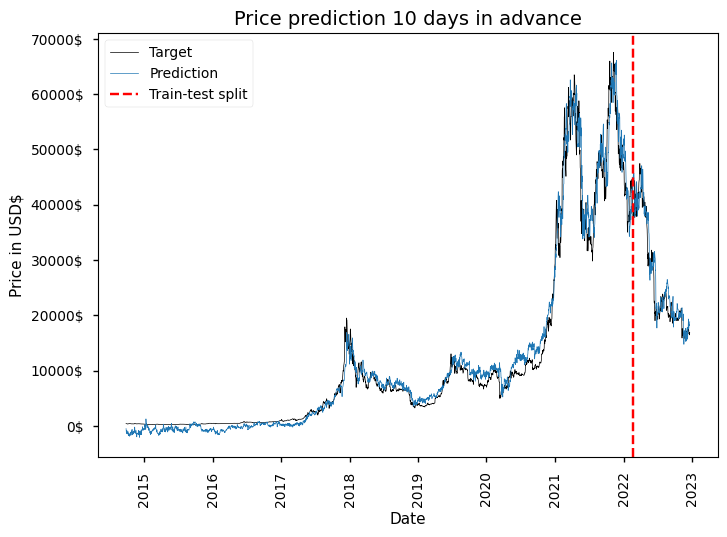

In [26]:
test_prediction = pd.Series(prediction, index=test_data.index)
train_pred = pd.Series(model.predict(train_data), index=train_data.index)
visualizer = Visualizer()
fig = visualizer.draw_prediction_full(train_target,train_pred, test_target, test_prediction, 10)
fig.show()

/tmp/ipykernel_15845/4071368209.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


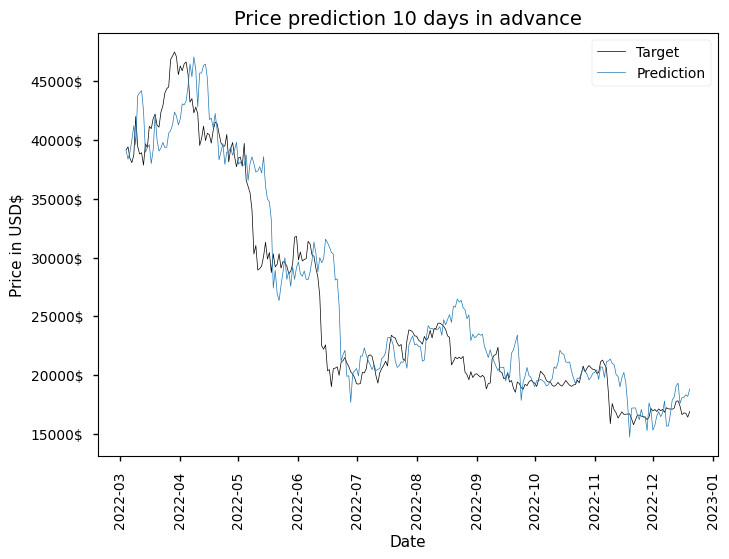

In [27]:
fig = visualizer.draw_prediction_test(test_target, test_prediction, 10)
fig.show()

## Full dimensionality - LTSM


In [28]:
len(pipeline.data_1d_shift.columns)

42

In [29]:
pipeline.data_1d_shift.columns

Index(['BTC / Addresses, active, count', 'BTC / NVT, adjusted, 90d MA',
       'BTC / NVT, adjusted', 'BTC / Flow, in, to exchanges, USD',
       'BTC / Flow, out, from exchanges, USD',
       'BTC / Fees, transaction, mean, USD', 'BTC / Miner revenue, USD',
       'BTC / Capitalization, realized, USD',
       'BTC / Volatility, daily returns, 30d',
       'BTC / Volatility, daily returns, 180d', 'BTC / Difficulty, last',
       'BTC / Hash rate, mean', 'BTC / Revenue, per hash unit, USD',
       'BTC / Supply, Miner, held by all mining entities, USD',
       'BTC / Block, size, mean, bytes', 'BTC / Block, weight, mean',
       'BTC / Issuance, continuous, percent, daily',
       'BTC / Network distribution factor', 'BTC / Transactions, count',
       'Google_btc_search', 'Wiki_btc_search', 'Close_^DJI', 'Close_^GSPC',
       'Close_GC=F', 'Close_^VIX', 'Close_^IXIC', 'Close_SMH', 'Close_VGT',
       'Close_XSD', 'Close_IYW', 'Close_FTEC', 'Close_IGV', 'Close_QQQ',
       'Google_crypt

In [30]:
pipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(model = Pipeline.assembly_lstm,
                    verbose=0, random_state = 42, shuffle = True, 
                    batch_size = 200,epochs=300, input_shape=(3, 41),
                    units = 500), dim_reducer = None, shape_change = ((-1, 41), (-1,3,41)))
pipe

Pipeline(steps=[('pack_down', ReshapeTransformer(new_shape=(-1, 41))),
                ('scaler', StandardScaler()), ('denoiser', None),
                ('scaler 2', None),
                ('pack_up,', ReshapeTransformer(new_shape=(-1, 3, 41))),
                ('estimator',
                 KerasRegressor(batch_size=200, epochs=300, input_shape=(3, 41), model=<function Pipeline.assembly_lstm at 0x7efe39ddd4e0>, random_state=42, units=500, verbose=0))])

In [31]:
LSTM_PARAMETERS = {"estimator__units": [700,800,900],
    "estimator__epochs": [1000],
    "estimator__batch_size": [100]}
x,y = Pipeline.create_lstm_input(pipeline.data_1d_shift.copy(), pipeline.data_1d_shift.copy().iloc[:,-1], 3)
train_data, test_data, train_target, test_target = Pipeline.split_train_test([x,y], pandas = False)
# minimax = sklearn.preprocessing.MinMaxScaler((0,1))
# train_target = np.squeeze(minimax.fit_transform(train_target.reshape(-1, 1)))
# test_target = np.squeeze(minimax.transform(test_target.reshape(-1, 1)))
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LSTM_PARAMETERS, n_jobs =None)
results_train_averaged.loc[["Full dimensionality"],["BTC-LSTM - 1 day"]] = rmse(train_target.reshape(-1,1), model.predict(train_data).reshape(-1,1))
prediction = model.predict(test_data)
results_test.loc[["Full dimensionality"],["BTC-LSTM - 1 day"]] = rmse(test_target.reshape(-1,1), 
                                                                      model.predict(test_data).reshape(-1,1))

TypeError: Pipeline.fit_grid_search() missing 2 required positional arguments: 'pipeline' and 'parameter_grid'

In [ ]:
model.cv_results_

In [ ]:
model.best_params_

In [ ]:

model.best_score_


In [ ]:
plt.plot(np.concatenate([model.predict(train_data), model.predict(test_data)]), linewidth=0.5)
plt.plot(np.concatenate([train_target,test_target]), linewidth=0.5)

In [ ]:
results_train_averaged

In [ ]:
results_test

## Full dimensionality - 5 and 10 days - LSTM

In [ ]:
#5 days LSTM
pipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(model = Pipeline.assembly_lstm,
                    verbose=1, random_state = 42, shuffle = True, 
                    batch_size = 200,epochs=300, input_shape=(3, 41),
                    units = 500), dim_reducer = None, shape_change = ((-1, 41), (-1,3,41)))
x,y = Pipeline.create_lstm_input(pipeline.data_1d_shift.copy(), pipeline.data_1d_shift.copy().iloc[:,-1], 3)
train_data, test_data, train_target, test_target = Pipeline.split_train_test([x,y], pandas = False)
minimax = sklearn.preprocessing.MinMaxScaler((0,1))
train_target = np.squeeze(minimax.fit_transform(train_target.reshape(-1, 1)))
test_target = np.squeeze(minimax.transform(test_target.reshape(-1, 1)))
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LSTM_PARAMETERS, n_jobs = None)
results_train_averaged.loc[["Full dimensionality"],["BTC-LSTM - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["Full dimensionality"],["BTC-LSTM - 5 days"]] = rmse(minimax.inverse_transform(test_target.reshape(-1,1)), 
                                                                      minimax.inverse_transform(model.predict(test_data).reshape(-1,1)))
pipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(build_fn = Pipeline.assembly_lstm,
                    verbose=1, random_state = 42, shuffle = True, 
                    batch_size = 200,epochs=300, input_shape=(6, 52),
                    units = 500), dim_reducer = None, shape_change = ((-1, 52), (-1,6,52)))
x,y = Pipeline.create_lstm_input(pipeline.data_1d_shift.copy(), pipeline.data_1d_shift.copy().iloc[:,-1], 6)
train_data, test_data, train_target, test_target = Pipeline.split_train_test([x,y], pandas = False)
minimax = sklearn.preprocessing.MinMaxScaler((0,1))
train_target = np.squeeze(minimax.fit_transform(train_target.reshape(-1, 1)))
test_target = np.squeeze(minimax.transform(test_target.reshape(-1, 1)))
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LSTM_PARAMETERS, n_jobs = None)
results_train_averaged.loc[["Full dimensionality"],["BTC-LSTM - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["Full dimensionality"],["BTC-LSTM - 10 days"]] = rmse(minimax.inverse_transform(test_target.reshape(-1,1)), 
                                                                      minimax.inverse_transform(model.predict(test_data).reshape(-1,1)))

# Retained 95% of variance

## Retained 95% of variance - Linear Regression

In [ ]:
pca = PCA(n_components = 0.95)
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = pca)
pipe

In [ ]:
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_1d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["95% retained variance"],["BTC-LR - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["95% retained variance"],["BTC-LR - 1 day"]] = rmse(test_target,
                                                                prediction)

In [ ]:
#5 days LR
pca = PCA(n_components = 0.95)
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_5d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["95% retained variance"],["BTC-LR - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["95% retained variance"],["BTC-LR - 5 days"]] = rmse(test_target,
                                                                prediction)
#10 days LR
pca = PCA(n_components = 0.95)
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_10d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["95% retained variance"],["BTC-LR - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["95% retained variance"],["BTC-LR - 10 days"]] = rmse(test_target,
                                                                prediction)

## Retained 95% of variance - Support Vector Regression

In [ ]:
pca = PCA(n_components = 0.95)
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = pca)
pipe

In [ ]:
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_1d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["95% retained variance"],["BTC-SVR - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["95% retained variance"],["BTC-SVR - 1 day"]] = rmse(test_target,
                                                                prediction)

## Retained 95% of variance - 5 and 10 days - SVR

In [ ]:
#5 days SVR
pca = PCA(n_components = 0.95)
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_5d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["95% retained variance"],["BTC-SVR - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["95% retained variance"],["BTC-SVR - 5 days"]] = rmse(test_target,
                                                                prediction)
#10 days SVR
pca = PCA(n_components = 0.95)
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_10d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["95% retained variance"],["BTC-SVR - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["95% retained variance"],["BTC-SVR - 10 days"]] = rmse(test_target,
                                                                prediction)

## Retained 95% of variance - LSTM

In [ ]:
pca = PCA(n_components = 0.95)
pipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(build_fn = Pipeline.assembly_lstm,
                    verbose=0, random_state = 42, shuffle = False, 
                    batch_size = 70,epochs=500, input_shape=(1, 52),
                    units = 2000), dim_reducer = pca, shape_change = ((-1, 52), (-1,1,52)))
pipe

In [ ]:
results_test

In [ ]:
x,y = Pipeline.create_lstm_input(pipeline.data_1d_shift.copy(), pipeline.data_1d_shift.copy().iloc[:,-1], 1, 1)
train_data, test_data, train_target, test_target = Pipeline.split_train_test([x,y], pandas = False)
minimax = sklearn.preprocessing.MinMaxScaler((0,1))
train_target = np.squeeze(minimax.fit_transform(train_target.reshape(-1, 1)))
test_target = np.squeeze(minimax.transform(test_target.reshape(-1, 1)))
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LSTM_PARAMETERS, n_jobs = None)
results_train_averaged.loc[["95% retained variance"],["BTC-LSTM - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["95% retained variance"],["BTC-LSTM - 1 day"]] = rmse(minimax.inverse_transform(test_target.reshape(-1,1)), 
                                                                      minimax.inverse_transform(model.predict(test_data).reshape(-1,1)))

## Retained 95% of variance - 5 and 10 days - LSTM

In [ ]:
#5 days LSTM
pca = PCA(n_components = 0.95)
pipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(model = Pipeline.assembly_lstm,
                    verbose=0, random_state = 42, shuffle = False, 
                    batch_size = 70,epochs=500, input_shape=(1, 52),
                    units = 2000), dim_reducer = pca, shape_change = ((-1, 52), (-1,1,52)))
x,y = Pipeline.create_lstm_input(pipeline.data_5d_shift.copy(), pipeline.data_5d_shift.copy().iloc[:,-1], 1, 5)
train_data, test_data, train_target, test_target = Pipeline.split_train_test([x,y], pandas = False)
minimax = sklearn.preprocessing.MinMaxScaler((0,1))
train_target = np.squeeze(minimax.fit_transform(train_target.reshape(-1, 1)))
test_target = np.squeeze(minimax.transform(test_target.reshape(-1, 1)))
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LSTM_PARAMETERS, n_jobs = None)
results_train_averaged.loc[["95% retained variance"],["BTC-LSTM - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["95% retained variance"],["BTC-LSTM - 5 days"]] = rmse(minimax.inverse_transform(test_target.reshape(-1,1)), 
                                                                      minimax.inverse_transform(model.predict(test_data).reshape(-1,1)))
#10 days LSTM
pca = PCA(n_components = 0.95)
pipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(model = Pipeline.assembly_lstm,
                    verbose=0, random_state = 42, shuffle = False, 
                    batch_size = 70,epochs=500, input_shape=(1, 52),
                    units = 2000), dim_reducer = pca, shape_change = ((-1, 52), (-1,1,52)))
x,y = Pipeline.create_lstm_input(pipeline.data_10d_shift.copy(), pipeline.data_10d_shift.copy().iloc[:,-1], 1, 10)
train_data, test_data, train_target, test_target = Pipeline.split_train_test([x,y], pandas = False)
minimax = sklearn.preprocessing.MinMaxScaler((0,1))
train_target = np.squeeze(minimax.fit_transform(train_target.reshape(-1, 1)))
test_target = np.squeeze(minimax.transform(test_target.reshape(-1, 1)))
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LSTM_PARAMETERS, n_jobs = None)
results_train_averaged.loc[["95% retained variance"],["BTC-LSTM - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["95% retained variance"],["BTC-LSTM - 10 days"]] = rmse(minimax.inverse_transform(test_target.reshape(-1,1)), 
                                                                      minimax.inverse_transform(model.predict(test_data).reshape(-1,1)))

# Retained 98% of variance

## Retained 98% of variance - Linear Regression

In [ ]:
pca = PCA(n_components = 0.98)
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = pca)
pipe

In [ ]:
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_1d_shift)
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["98% retained variance"],["BTC-LR - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["98% retained variance"],["BTC-LR - 1 day"]] = rmse(test_target,
                                                                prediction)

In [ ]:
#5 days LR
pca = PCA(n_components = 0.98)
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_5d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["98% retained variance"],["BTC-LR - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["98% retained variance"],["BTC-LR - 5 days"]] = rmse(test_target,
                                                                prediction)
#10 days LR
pca = PCA(n_components = 0.98)
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_10d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["98% retained variance"],["BTC-LR - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["98% retained variance"],["BTC-LR - 10 days"]] = rmse(test_target,
                                                                prediction)

## Retained 98% of variance - Support Vector Regression

In [ ]:
pca = PCA(n_components = 0.98)
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = pca)
pipe

In [ ]:
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_1d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["98% retained variance"],["BTC-SVR - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["98% retained variance"],["BTC-SVR - 1 day"]] = rmse(test_target,
                                                                prediction)

## Retained 98% of variance - 5 and 10 days - SVR

In [ ]:
#5 days SVR
pca = PCA(n_components = 0.98)
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_5d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["98% retained variance"],["BTC-SVR - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["98% retained variance"],["BTC-SVR - 5 days"]] = rmse(test_target,
                                                                prediction)
#10 days SVR
pca = PCA(n_components = 0.98)
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_10d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["98% retained variance"],["BTC-SVR - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["98% retained variance"],["BTC-SVR - 10 days"]] = rmse(test_target,
                                                                prediction)

## Retained 98% of variance - LSTM

In [ ]:
pca = PCA(n_components = 0.98)
pipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(model = Pipeline.assembly_lstm,
                    verbose=0, random_state = 42, shuffle = False, 
                    batch_size = 70,epochs=500, input_shape=(1, 52),
                    units = 2000), dim_reducer = pca, shape_change = ((-1, 52), (-1,1,52)))
pipe

In [ ]:
x,y = Pipeline.create_lstm_input(pipeline.data_1d_shift.copy(), pipeline.data_1d_shift.copy().iloc[:,-1], 1, 1)
train_data, test_data, train_target, test_target = Pipeline.split_train_test([x,y], pandas = False)
minimax = sklearn.preprocessing.MinMaxScaler((0,1))
train_target = np.squeeze(minimax.fit_transform(train_target.reshape(-1, 1)))
test_target = np.squeeze(minimax.transform(test_target.reshape(-1, 1)))
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LSTM_PARAMETERS, n_jobs = None)
results_train_averaged.loc[["98% retained variance"],["BTC-LSTM - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["98% retained variance"],["BTC-LSTM - 1 day"]] = rmse(minimax.inverse_transform(test_target.reshape(-1,1)), 
                                                                      minimax.inverse_transform(model.predict(test_data).reshape(-1,1)))

## Retained 98% of variance - 5 and 10 days - LSTM

In [ ]:
#5 days LSTM
pca = PCA(n_components = 0.98)
pipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(model = Pipeline.assembly_lstm,
                    verbose=0, random_state = 42, shuffle = False, 
                    batch_size = 70,epochs=500, input_shape=(1, 52),
                    units = 2000), dim_reducer = pca, shape_change = ((-1, 52), (-1,1,52)))
x,y = Pipeline.create_lstm_input(pipeline.data_5d_shift.copy(), pipeline.data_5d_shift.copy().iloc[:,-1], 1, 5)
train_data, test_data, train_target, test_target = Pipeline.split_train_test([x,y], pandas = False)
minimax = sklearn.preprocessing.MinMaxScaler((0,1))
train_target = np.squeeze(minimax.fit_transform(train_target.reshape(-1, 1)))
test_target = np.squeeze(minimax.transform(test_target.reshape(-1, 1)))
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LSTM_PARAMETERS, n_jobs = None)
results_train_averaged.loc[["98% retained variance"],["BTC-LSTM - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["98% retained variance"],["BTC-LSTM - 5 days"]] = rmse(minimax.inverse_transform(test_target.reshape(-1,1)), 
                                                                      minimax.inverse_transform(model.predict(test_data).reshape(-1,1)))
#10 days LSTM
pca = PCA(n_components = 0.98)
pipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(model = Pipeline.assembly_lstm,
                    verbose=0, random_state = 42, shuffle = False, 
                    batch_size = 70,epochs=500, input_shape=(1, 52),
                    units = 2000), dim_reducer = pca, shape_change = ((-1, 52), (-1,1,52)))
x,y = Pipeline.create_lstm_input(pipeline.data_10d_shift.copy(), pipeline.data_10d_shift.copy().iloc[:,-1], 1, 10)
train_data, test_data, train_target, test_target = Pipeline.split_train_test([x,y], pandas = False)
minimax = sklearn.preprocessing.MinMaxScaler((0,1))
train_target = np.squeeze(minimax.fit_transform(train_target.reshape(-1, 1)))
test_target = np.squeeze(minimax.transform(test_target.reshape(-1, 1)))
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LSTM_PARAMETERS, n_jobs = None)
results_train_averaged.loc[["98% retained variance"],["BTC-LSTM - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["98% retained variance"],["BTC-LSTM - 10 days"]] = rmse(minimax.inverse_transform(test_target.reshape(-1,1)), 
                                                                      minimax.inverse_transform(model.predict(test_data).reshape(-1,1)))

# Retained 99% of variance

## Retained 99% of variance - Linear Regression

In [ ]:
pca = PCA(n_components = 0.99)
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = pca)
pipe

In [ ]:
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_1d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["99% retained variance"],["BTC-LR - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["99% retained variance"],["BTC-LR - 1 day"]] = rmse(test_target,
                                                                prediction)

In [ ]:
#5 days LR
pca = PCA(n_components = 0.99)
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_5d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["99% retained variance"],["BTC-LR - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["99% retained variance"],["BTC-LR - 5 days"]] = rmse(test_target,
                                                                prediction)
#10 days LR
pca = PCA(n_components = 0.99)
pipe = Pipeline.assembly_pipeline(estimator = Ridge(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.data_10d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LR_PARAMETERS)
results_train_averaged.loc[["99% retained variance"],["BTC-LR - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["99% retained variance"],["BTC-LR - 10 days"]] = rmse(test_target,
                                                                prediction)

## Retained 99% of variance - Support Vector Regression

In [ ]:
pca = PCA(n_components = 0.99)
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = pca)
pipe

In [ ]:
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_1d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["99% retained variance"],["BTC-SVR - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["99% retained variance"],["BTC-SVR - 1 day"]] = rmse(test_target,
                                                                prediction)

In [ ]:
#5 days SVR
pca = PCA(n_components = 0.99)
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_5d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["99% retained variance"],["BTC-SVR - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["99% retained variance"],["BTC-SVR - 5 days"]] = rmse(test_target,
                                                                prediction)
#10 days SVR
pca = PCA(n_components = 0.99)
pipe = Pipeline.assembly_pipeline(estimator = LinearSVR(random_state = 42), dim_reducer = pca)
train_data, test_data, train_target, test_target = Pipeline.split_train_test(pipeline.
                                                                data_10d_shift.copy())
model = Pipeline.fit_grid_search(train_data, train_target, pipe, SVR_PARAMETERS)
results_train_averaged.loc[["99% retained variance"],["BTC-SVR - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["99% retained variance"],["BTC-SVR - 10 days"]] = rmse(test_target,
                                                                prediction)

In [ ]:
test_prediction = pd.Series(prediction, index=test_data.index)
train_pred = pd.Series(model.predict(train_data), index=train_data.index)
visualizer = Visualizer()
fig = visualizer.draw_prediction_full(train_target,train_pred, test_target, test_prediction, 10)
fig.show()

## Retained 99% of variance - LSTM

In [ ]:
pca = PCA(n_components = 0.99)
pipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(model = Pipeline.assembly_lstm,
                    verbose=0, random_state = 42, shuffle = False, 
                    batch_size = 70,epochs=500, input_shape=(1, 52),
                    units = 2000), dim_reducer = pca, shape_change = ((-1, 52), (-1,1,52)))
pipe

In [ ]:
x,y = Pipeline.create_lstm_input(pipeline.data_1d_shift.copy(), pipeline.data_1d_shift.copy().iloc[:,-1], 1, 1)
train_data, test_data, train_target, test_target = Pipeline.split_train_test([x,y], pandas = False)
minimax = sklearn.preprocessing.MinMaxScaler((0,1))
train_target = np.squeeze(minimax.fit_transform(train_target.reshape(-1, 1)))
test_target = np.squeeze(minimax.transform(test_target.reshape(-1, 1)))
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LSTM_PARAMETERS, n_jobs = None)
results_train_averaged.loc[["99% retained variance"],["BTC-LSTM - 1 day"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["99% retained variance"],["BTC-LSTM - 1 day"]] = rmse(minimax.inverse_transform(test_target.reshape(-1,1)), 
                                                                      minimax.inverse_transform(model.predict(test_data).reshape(-1,1)))

In [ ]:
#5 days LSTM
pca = PCA(n_components = 0.99)
pipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(model = Pipeline.assembly_lstm,
                    verbose=0, random_state = 42, shuffle = False, 
                    batch_size = 70,epochs=500, input_shape=(1, 52),
                    units = 2000), dim_reducer = pca, shape_change = ((-1, 52), (-1,1,52)))
x,y = Pipeline.create_lstm_input(pipeline.data_5d_shift.copy(), pipeline.data_5d_shift.copy().iloc[:,-1], 1, 5)
train_data, test_data, train_target, test_target = Pipeline.split_train_test([x,y], pandas = False)
minimax = sklearn.preprocessing.MinMaxScaler((0,1))
train_target = np.squeeze(minimax.fit_transform(train_target.reshape(-1, 1)))
test_target = np.squeeze(minimax.transform(test_target.reshape(-1, 1)))
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LSTM_PARAMETERS, n_jobs = None)
results_train_averaged.loc[["99% retained variance"],["BTC-LSTM - 5 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["99% retained variance"],["BTC-LSTM - 5 days"]] = rmse(minimax.inverse_transform(test_target.reshape(-1,1)), 
                                                                      minimax.inverse_transform(model.predict(test_data).reshape(-1,1)))
#10 days LSTM
pca = PCA(n_components = 0.99)
pipe = Pipeline.assembly_pipeline(estimator = KerasRegressor(model = Pipeline.assembly_lstm,
                    verbose=0, random_state = 42, shuffle = False, 
                    batch_size = 70,epochs=500, input_shape=(1, 52),
                    units = 2000), dim_reducer = pca, shape_change = ((-1, 52), (-1,1,52)))
x,y = Pipeline.create_lstm_input(pipeline.data_10d_shift.copy(), pipeline.data_10d_shift.copy().iloc[:,-1], 1, 10)
train_data, test_data, train_target, test_target = Pipeline.split_train_test([x,y], pandas = False)
minimax = sklearn.preprocessing.MinMaxScaler((0,1))
train_target = np.squeeze(minimax.fit_transform(train_target.reshape(-1, 1)))
test_target = np.squeeze(minimax.transform(test_target.reshape(-1, 1)))
model = Pipeline.fit_grid_search(train_data, train_target, pipe, LSTM_PARAMETERS, n_jobs = None)
results_train_averaged.loc[["99% retained variance"],["BTC-LSTM - 10 days"]] = model.best_score_
prediction = model.predict(test_data)
results_test.loc[["99% retained variance"],["BTC-LSTM - 10 days"]] = rmse(minimax.inverse_transform(test_target.reshape(-1,1)), 
                                                                      minimax.inverse_transform(model.predict(test_data).reshape(-1,1)))

In [ ]:
results_test